## 设置经验回放库

设置经验回放有助于提高算法的效率，对于一个经验回放库通常有以下几个方法:

1. `push`: 将数据存储起来。
2. `sample`: 将数据从经验库中采样出来。

```python
class ReplayBuffer(object):
    def __init__(self, size):
        super(ReplayBuffer, self).__init__()
        pass
    
    def push(self, state, action, reward, next_state, done):
        pass
    
    def sample(self, batch_size):
        pass
    
    def __len__(self):
        pass
```

In [1]:
import random
import numpy as np

class ReplayBuffer(object):
    def __init__(self, size):
        """
        创建一个Buffer。
        """
        self.buffer = []
        self._maxsize = size
        self.cnt = 0
        
    def __len__(self):
        """
        返回buffer的长度。
        """
        return len(self.buffer)

    def push(self, state, action, reward, next_state, done):
        """
        
        """
        data = (state, action, reward, next_state, done)

        if len(self.buffer) == self._maxsize:
            self.buffer = self.buffer[1:]
            
        self.buffer.append(data)
        
    def sample(self, batch_size):
        
        #<randomly generate batch_size integers to be used as indexes of samples>
        buffer_size = len(self.buffer)
        idxes = np.random.randint(buffer_size, size = batch_size)
        
        state, action, reward, next_state, done = zip(*[self.buffer[idx] for idx in idxes])
        
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

In [2]:
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.push(*obj1)
print(replay.sample(1))
print(obj1)
assert replay.sample(1)==obj1, "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.push(*obj2)
assert len(replay.buffer)==2, "Please make sure __len__ methods works as intended."
replay.push(*obj2)
assert len(replay.buffer)==2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100))==obj2
replay.push(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100))==2
replay.push(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100))==obj1
print ("Success!")

(array([0]), array([1]), array([2]), array([3]), array([4]))
(0, 1, 2, 3, 4)
Success!


## 设置智能体

In [3]:
from collections import defaultdict
class QLearningAgent(object):
    def __init__(self, env, learning_rate, epsilon, discount):
        super(QLearningAgent, self).__init__()
        self.legal_action = range(env.action_space.n)  # 获取合法的动作
        
        self.epsilon = epsilon
        self.discount = discount
        self.q_table = defaultdict(lambda: defaultdict(lambda: 0))
        self.lr = learning_rate
    
    def get_action(self, state):
        """
        依据状态选择动作, 加入合法动作是为了方便之后用于复杂环境留的接口
        
        基于epsilon贪婪策略选择动作。
        self.epsilon概率选择随机动作，1 - self.epsilon概率选择最好的动作。
        
        """
        possible_actions = self.legal_action
        
        if len(possible_actions) == 0:
            print("return None")
            return None
        
        epsilon = self.epsilon
        
        if np.random.random() > epsilon:
            possible_q_values = [self.q_table[state][action] for action in possible_actions]
            index = np.argmax(possible_q_values)
            
            return possible_actions[index]
        else:
            
            return random.choice(possible_actions)
    
    def update_agent(self, state, action, reward, next_state):
        """
        Q值更新公式如下:
        Q(s,a) := (1 - lr) * Q(s,a) + lr * (r + gamma * V(s'))
        """
        current_q = self.q_table[state][action]
        
        next_state_possible_actions = self.legal_action
        
        next_v = np.max([self.q_table[next_state][next_action] for next_action in next_state_possible_actions])
        
        new_q = (1 - self.lr) * current_q + self.lr * (reward + self.discount * next_v)
        
        self.q_table[state][action] = new_q

In [4]:
import gym
env = gym.make("Taxi-v3")

In [5]:
agent_base = QLearningAgent(env, learning_rate=0.5, epsilon=0.25,discount=0.99)
agent_replay = QLearningAgent(env, learning_rate=0.5, epsilon=0.25,discount=0.99)

In [6]:
def play_and_train_with_replay(env, agent, replay = None, t_max = 10**4, replay_batch_size = 32):
    total_reward = 0
    s = env.reset()
    for i in range(t_max):
        a = agent.get_action(s)
        next_s, r, done, info = env.step(a)
        total_reward += r
        
        if done: break
        
        agent.update_agent(s, a, r, next_s)
        
        if replay is not None:
            replay.push(s, a, r, next_s, done)
            
            array_s, array_a, array_r, array_s_next, array_done = replay.sample(replay_batch_size)
            
            for i in range(replay_batch_size):
                agent.update_agent(array_s[i], array_a[i], array_r[i], array_s_next[i])
        s = next_s
        
    return total_reward

Baseline : eps = 2.9191091959171894e-05 mean reward = 5.3
ExpReplay: eps = 2.9191091959171894e-05 mean reward = 8.1


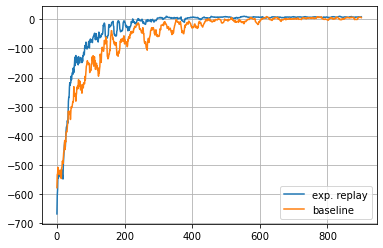

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
# from pandas import ewma, Series
# moving_average = lambda ts, span=100: ewma(Series(ts), min_periods=span//10, span=span).values

avg_rewards_replay = []
avg_rewards_baseline = []
rewards_replay, rewards_baseline = [], []

for i in range(1000):
    rewards_replay.append(play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(play_and_train_with_replay(env, agent_base, replay=None))
    
    avg_rewards_replay.append(np.mean(rewards_replay[-min(10, len(rewards_replay)):]))
    avg_rewards_baseline.append(np.mean(rewards_baseline[-min(10, len(rewards_baseline)):]))
    
    agent_replay.epsilon *= 0.99
    agent_base.epsilon *= 0.99
    
    if i %100 ==0:
        clear_output(True)
        print('Baseline : eps =', agent_replay.epsilon, 'mean reward =', np.mean(rewards_baseline[-10:]))
        print('ExpReplay: eps =', agent_base.epsilon, 'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(avg_rewards_replay, label='exp. replay')
        plt.plot(avg_rewards_baseline, label='baseline')
        plt.grid()
        plt.legend()
        plt.show()